## Camera API tutorial for OpenCood
This tutorial will go through the basic camera related APIs of Opencood library for dataset OPV2V

In [1]:
import os
import sys
parent_path = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))
sys.path.append(parent_path)

import torch
from torch.utils.data import DataLoader

from opencood.data_utils.datasets.camera_only.base_camera_dataset import BaseCameraDataset

### Load configuration file
To make everything managable easily, we set all parameters for dataset in a configuration file. The most important parameters for creating the dataset class are:
- `root_dir`: the path to the train subset
- `validate_dir`: the path to the testing/validation subset
- `fusion`: this decides which dataset class you want to use, e.g. lidar late fusion or early fusion or camera fusion
- `cav_lidar_range`: The range that covers all considered objects 

In [2]:
from opencood.hypes_yaml.yaml_utils import load_yaml
params = load_yaml('../opencood/hypes_yaml/opcamera/base_camera.yaml')
print(params)

{'name': 'base_camera', 'root_dir': '/home/runshengxu/project/OpenCDA/data_dumping/train', 'validate_dir': '/home/runshengxu/project/OpenCDA/data_dumping/validate', 'train_params': {'batch_size': 4, 'epoches': 22, 'eval_freq': 1, 'save_freq': 1}, 'fusion': {'core_method': 'BaseCameraDataset', 'args': []}, 'data_augment': [], 'preprocess': {'core_method': 'BasePreprocessor', 'args': [], 'cav_lidar_range': [-50.8, -40, -5, 50.8, 40, 1]}, 'postprocess': {'core_method': 'BasePostprocessor', 'anchor_args': {'cav_lidar_range': [-50.8, -40, -5, 50.8, 40, 1]}, 'order': 'hwl', 'max_num': 100, 'nms_thresh': 0.15}}


## Create the camera dataset
Next we need to initialze the dataset manage class by giving:
- `params`: the configuration of the dataset.
- `train`: if train, class will load from root_dir. else, it will load data from path validate_dir
- `save_origin_lidar`: Whether to load lidar cloud point as well for visualization
### Important variables inside the class
- `scenario_database`: It contains all scenario information inside the data. In each scenario, it will contain multiple agents' information and each agent has multiple timestamps data, which includes camera images, lidar points, and metadata.
- `param`: The loaded configuration.

In [3]:
opencood_dataset = BaseCameraDataset(params, train=True, save_origin_lidar=True)

## Load data by giving a certain scenario index and a certain timestamp index
Opencood supports 2 different methods to load the data from the OPV2V database. First is giving the specific scenario index and timestamp index.

In [4]:
data_sample = opencood_dataset.get_sample(11, 10)

## Data sample structure:
The retrieved data sample is a dictionary:
- `cav_id`: the agent's id
    - `ego`: whether it is the ego vehicle in this scenario
    - `camera_params`: all four camera's parameters
        - `camera_id`: the current camera id, from camera_0 to camera_3
            - `camera_coords`: camera coordinates under carla world
            - `camera_extrinsic`: extrinsic matrix from the current agent's LiDAR to camera
            - `camera_intrinsic`: camera intrinsic matrix
            - `camera_extrinsic_ego`: extrinsic matrix from Ego vehicle's LiDAR to camera
    - `object_bbx_cav`: The coordinates of the objects which can be peceived by the current agent. The 
    coordinates are under current agent's LiDAR coordinate frame and is a numpy array with shape of (N,7)-> x,y,z,
    h,w,l,r(raw angle)
    - `object_bbx_ego`: The coordinates of the objects that are peceived by all agents in the current scenario.   The coordinates are under Ego vehicle's LiDAR coordinate frame and is a numpy array with shape of (max_n, 7). **This attribute only exist under ego vehicle**.
    - `object_bbx_ego_mask`: Show which rows in `object_bbx_ego` are valid. The rest of the rows are just zero padding. **This attribute only exist under ego vehicle**.
    - `camera_np`: A list of numpy array. It contains all rgb images of 4 cameras.
    
            

In [25]:
print('Agent 4740 camera0 params: \n', data_sample['4740']['camera_params']['camera0']['camera_coords'])
print('Agent 4740  camera0 extrinsic: \n', data_sample['4740']['camera_params']['camera0']['camera_extrinsic'])
print('Agent 4740  camera0 intrinsic: \n', data_sample['ego']['camera_params']['camera0']['camera_intrinsic'])
print('Agent 4740  camera0 extrinsic (from ego lidar): \n', data_sample['4740']['camera_params']['camera0']['camera_extrinsic_ego'])
print('Objects coordinates under agent 4740 LiDAR coordinate frame: \n', data_sample['4740']['object_bbx_cav'])
print('Objects coordinates under agent ego LiDAR coordinate frame: \n', data_sample['ego']['object_bbx_ego'])
# print('ego vehicle camera0 params:', data_sample['ego']['camera_params']['camera0'])


Agent 4740 camera0 params: 
 [-164.29562377929688, 84.31495666503906, 1.0278782844543457, -0.004394530784338713, -179.6320037841797, -0.16555695235729218]
Agent 4740  camera0 extrinsic: 
 [[ 1.00000000e+00  3.35557396e-19 -4.33680869e-19 -2.99998979e+00]
 [-5.31857282e-19  1.00000000e+00  1.35525272e-20  2.65648482e-06]
 [ 0.00000000e+00 -1.35525272e-20  1.00000000e+00  9.00000082e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Agent 4740  camera0 intrinsic: 
 [[335.63985247   0.         400.        ]
 [  0.         335.63985247 300.        ]
 [  0.           0.           1.        ]]
Agent 4740  camera0 extrinsic (from ego lidar): 
 [[-9.99925870e-01 -1.08614085e-02 -5.50306481e-03  4.38304862e+01]
 [ 1.08610297e-02 -9.99941012e-01  9.87005936e-05 -7.28754999e+00]
 [-5.50381223e-03  3.89243264e-05  9.99984853e-01  1.03560742e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Objects coordinates under agent 4740 LiDAR coordinate frame: 
 [

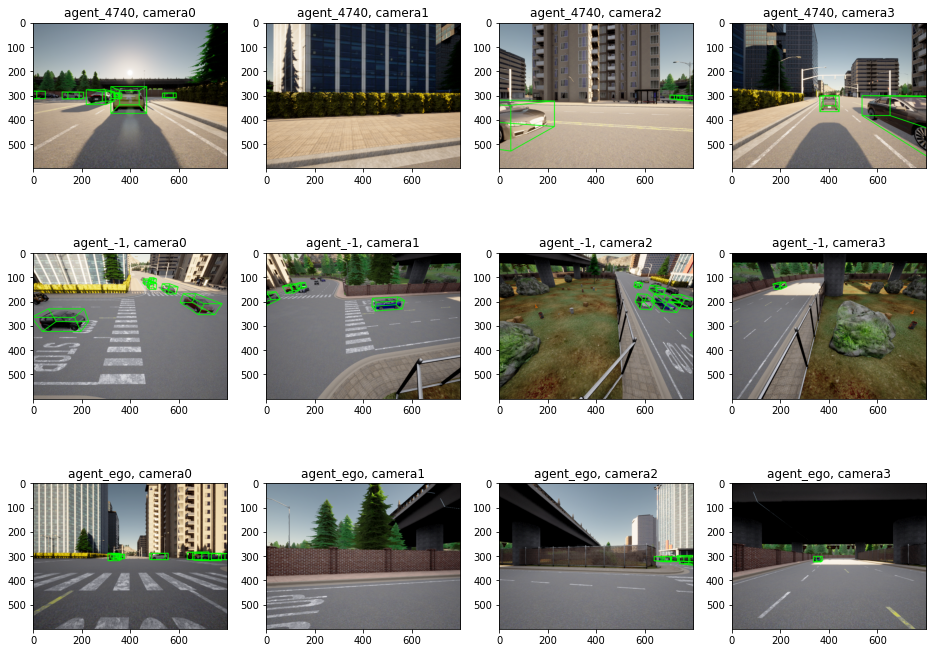

In [26]:
from opencood.utils import camera_utils
draw_image_list, cav_id_list = opencood_dataset.visualize_all_agents_bbx(data_sample)
camera_utils.plot_all_agents(draw_image_list, cav_id_list)